In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV,  TimeSeriesSplit, KFold
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import optuna
import shap
from tqdm import tqdm
import warnings
import importlib
import long_term_utils
importlib.reload(long_term_utils)
from long_term_utils import ( 
    map_agrofon_to_group
)


In [2]:
warnings.filterwarnings("ignore")

In [274]:
#Loading Data for Model Training
crop_yield_df = pd.read_csv(r'new_ml_data.csv')
crop_yield_df.drop(columns=['date'], inplace=True)
crop_yield_df = crop_yield_df.sort_values(by='Year', ascending=True).reset_index(drop=True)
print(crop_yield_df.shape)
crop_yield_df.head()


(2516, 49)


,Подразделение,Поле,Field_ID,Year,Area,Yield,Агрофон,Культура,MAX_NDVI,6_NDVI,...,8_vapor_pressure_deficit,DOY_min,DOY_max,bdod,cec,clay,phh2o,sand,silt,soc
0,Абайское,16254,235Абайское,2020,230.0,13.1,Стерня,Тризо,0.497964,0.259751,...,0.899491,150,151,100.337298,397.188277,297.142827,67.811299,329.994797,372.765637,704.696368
1,Золотой колос,68,2274Золотой колос,2020,449.0,12.9,Пар чистый,Урало-Сибирская,0.706052,0.400413,...,0.905292,135,138,97.778689,446.412099,281.256845,66.651730,345.383682,373.249249,786.858907
2,Золотой колос,69П-2,2279Золотой колос,2020,93.0,12.6,Стерня,Урало-Сибирская,0.678590,0.426735,...,0.905292,135,135,98.676440,441.562154,291.166799,65.828451,336.994458,372.006070,854.671157
3,Золотой колос,70 П,2281Золотой колос,2020,332.0,19.0,Пар чистый,Урало-Сибирская,0.794868,0.447238,...,0.905292,137,138,99.046297,436.128137,295.289637,66.173014,337.942722,366.822114,838.569593
4,Золотой колос,76,2283Золотой колос,2020,260.0,10.7,Пар чистый,Урало-Сибирская,0.802729,0.376903,...,0.864318,143,147,96.475710,407.573264,283.320453,66.333207,387.585073,329.021068,758.627299


In [282]:
#OUTLIER REMOVAL THROUGH IQR
merged_df = crop_yield_df.copy()
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    no_outlier_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return no_outlier_df

no_outlier_df = remove_outliers(merged_df, 'Yield')
no_outlier_df = no_outlier_df.reset_index(drop=True)

print("Shape of data before removing outliers:",crop_yield_df.shape)
print("Shape of dataframe after removing outliers:", no_outlier_df.shape)
print("Number of Wheat Crops Sown Per Year:\n", no_outlier_df['Year'].value_counts())
no_outlier_df.head(10)

Shape of data before removing outliers: (2516, 48)
Shape of dataframe after removing outliers: (2472, 48)
Number of Wheat Crops Sown Per Year:
 Year
2021    588
2020    560
2023    474
2024    456
2022    394
Name: count, dtype: int64


,Подразделение,Поле,Field_ID,Year,Area,Yield,Агрофон,Культура,MAX_NDVI,6_NDVI,...,8_vapor_pressure_deficit,DOY_min,DOY_max,bdod,cec,clay,phh2o,sand,silt,soc
0,Абайское,16254,235Абайское,2020,230.0,13.1,Стерня,Тризо,0.497964,0.259751,...,0.899491,150,151,100.337298,397.188277,297.142827,67.811299,329.994797,372.765637,704.696368
1,Золотой колос,68,2274Золотой колос,2020,449.0,12.9,Пар чистый,Урало-Сибирская,0.706052,0.400413,...,0.905292,135,138,97.778689,446.412099,281.256845,66.651730,345.383682,373.249249,786.858907
2,Золотой колос,69П-2,2279Золотой колос,2020,93.0,12.6,Стерня,Урало-Сибирская,0.678590,0.426735,...,0.905292,135,135,98.676440,441.562154,291.166799,65.828451,336.994458,372.006070,854.671157
3,Золотой колос,70 П,2281Золотой колос,2020,332.0,19.0,Пар чистый,Урало-Сибирская,0.794868,0.447238,...,0.905292,137,138,99.046297,436.128137,295.289637,66.173014,337.942722,366.822114,838.569593
4,Золотой колос,76,2283Золотой колос,2020,260.0,10.7,Пар чистый,Урало-Сибирская,0.802729,0.376903,...,0.864318,143,147,96.475710,407.573264,283.320453,66.333207,387.585073,329.021068,758.627299
5,Золотой колос,76 П,2284Золотой колос,2020,156.0,20.5,Пар чистый,Урало-Сибирская,0.788107,0.458994,...,0.907729,139,139,97.180755,445.753858,304.090551,66.108976,347.627087,348.334488,761.351872
6,Золотой колос,78,2287Золотой колос,2020,192.0,21.3,Пар чистый,others,0.732348,0.357459,...,0.871087,141,151,95.305779,454.270825,296.283327,66.653272,369.746269,333.983799,821.407067
7,Золотой колос,85-1,2294Золотой колос,2020,95.0,12.1,Пар чистый,Шортандинская,0.505691,0.236240,...,0.856418,149,150,95.086362,423.322065,297.106839,67.335484,320.878194,381.808516,722.440835
8,Золотой колос,85а-1,2296Золотой колос,2020,59.6,12.1,Пар чистый,Шортандинская,0.797783,0.306717,...,0.856418,147,149,94.850967,419.811523,290.300823,67.159671,331.107407,378.393827,802.212433
9,Золотой колос,90,2302Золотой колос,2020,271.0,11.2,Пар чистый,Шортандинская,0.834952,0.310509,...,0.856696,147,147,99.496837,396.896792,308.470312,66.980750,337.273565,354.196204,582.768661


In [418]:
print( "Summary of Yield", no_outlier_df['Yield'].describe())

Summary of Yield count    2472.000000
mean       15.628204
std         6.555567
min         1.000000
25%        10.707500
50%        14.900000
75%        19.900000
max        34.000000
Name: Yield, dtype: float64


In [353]:
#Data 80/20 Train/Test Split For Model Training
ix_trn, ix_val = train_test_split(
    no_outlier_df.index,
    test_size=0.2,
    random_state=42,
    stratify=no_outlier_df['Year']
)
print(ix_trn.shape)
print(ix_val.shape)
ix_tst = ix_val.copy()

(1977,)
(495,)


In [403]:
#Remove Unwanted Columns Before Model Training
pre_process_df = no_outlier_df.copy(deep=True)
features_to_remove = [
    'Подразделение',
    'Поле',
    'Field_ID',
    'Area',
    'Культура',
    '6_NDVI',
    'Year',
]
# df_2024_test = pre_process_df[pre_process_df['Year'].isin([2024])]
# ix_val_2024 = df_2024_test.index    
pre_process_df = pre_process_df.drop(columns=features_to_remove)
id_columns = no_outlier_df[['Подразделение','Поле','Field_ID']].copy()
print(pre_process_df.columns)
print(pre_process_df.shape)
pre_process_df.head(6)

Index(['Yield', 'Агрофон', 'MAX_NDVI', '7_NDVI', '5_relative_humidity',
       '6_relative_humidity', '7_relative_humidity', '8_relative_humidity',
       '5_surface_solar_radiation_downwards_sum',
       '6_surface_solar_radiation_downwards_sum',
       '7_surface_solar_radiation_downwards_sum',
       '8_surface_solar_radiation_downwards_sum', '5_temperature_2m_max',
       '6_temperature_2m_max', '7_temperature_2m_max', '8_temperature_2m_max',
       '5_temperature_2m_min', '6_temperature_2m_min', '7_temperature_2m_min',
       '8_temperature_2m_min', '5_total_precipitation_sum',
       '6_total_precipitation_sum', '7_total_precipitation_sum',
       '8_total_precipitation_sum', '5_v_component_of_wind_10m',
       '6_v_component_of_wind_10m', '7_v_component_of_wind_10m',
       '8_v_component_of_wind_10m', '5_vapor_pressure_deficit',
       '6_vapor_pressure_deficit', '7_vapor_pressure_deficit',
       '8_vapor_pressure_deficit', 'DOY_min', 'DOY_max', 'bdod', 'cec', 'clay',
       '

,Yield,Агрофон,MAX_NDVI,7_NDVI,5_relative_humidity,6_relative_humidity,7_relative_humidity,8_relative_humidity,5_surface_solar_radiation_downwards_sum,6_surface_solar_radiation_downwards_sum,...,8_vapor_pressure_deficit,DOY_min,DOY_max,bdod,cec,clay,phh2o,sand,silt,soc
0,13.1,Стерня,0.497964,0.466679,54.604540,46.424682,50.769116,60.710184,6.508537e+08,6.797563e+08,...,0.899491,150,151,100.337298,397.188277,297.142827,67.811299,329.994797,372.765637,704.696368
1,12.9,Пар чистый,0.706052,0.634758,59.293773,52.547934,54.264657,60.864747,6.645415e+08,6.609843e+08,...,0.905292,135,138,97.778689,446.412099,281.256845,66.651730,345.383682,373.249249,786.858907
2,12.6,Стерня,0.678590,0.604503,59.293773,52.547934,54.264657,60.864747,6.645415e+08,6.609843e+08,...,0.905292,135,135,98.676440,441.562154,291.166799,65.828451,336.994458,372.006070,854.671157
3,19.0,Пар чистый,0.794868,0.724622,59.293773,52.547934,54.264657,60.864747,6.645415e+08,6.609843e+08,...,0.905292,137,138,99.046297,436.128137,295.289637,66.173014,337.942722,366.822114,838.569593
4,10.7,Пар чистый,0.802729,0.724596,60.043111,52.817755,54.556699,62.289575,6.603885e+08,6.642376e+08,...,0.864318,143,147,96.475710,407.573264,283.320453,66.333207,387.585073,329.021068,758.627299
5,20.5,Пар чистый,0.788107,0.713867,59.228981,52.503539,54.238159,60.777760,6.648933e+08,6.606226e+08,...,0.907729,139,139,97.180755,445.753858,304.090551,66.108976,347.627087,348.334488,761.351872


In [386]:
# field_data = pd.concat([id_columns, pre_process_df], axis=1)
# test_2024_data = field_data.loc[ix_val_2024, :]
# test_2024_data.to_csv(r'test_2024.csv', index=False)


In [404]:
#Pre_Process Agrofon Column to group similar types of agriculture background together thus reducing the number features after one-hot encoding
pre_process_df = map_agrofon_to_group(pre_process_df)
# pre_process_df = pre_process_df.drop(columns=['Yield'])
# pre_process_df.to_csv(r'test.csv', index=False)

In [405]:
target = 'Yield'
numeric_features = list(pre_process_df.drop(['Агрофон', 'Yield'], axis=1).select_dtypes(include=['int64', 'float64']).columns)
categorical_features = ['Агрофон']

In [406]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the data
preprocessed_data = preprocessor.fit_transform(pre_process_df)
numeric_feature_names = numeric_features

categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_feature_names + categorical_feature_names.tolist()
preprocessed_df = pd.DataFrame(preprocessed_data, columns=all_feature_names, index=pre_process_df.index)
preprocessed_df['Yield'] = pre_process_df['Yield']
preprocessed_df = preprocessed_df.drop(columns = ['Агрофон_others'])
features = [f for f in preprocessed_df.columns if f != target]
print(features)
print(preprocessed_df.shape)
preprocessed_df.head(10)

['MAX_NDVI', '7_NDVI', '5_relative_humidity', '6_relative_humidity', '7_relative_humidity', '8_relative_humidity', '5_surface_solar_radiation_downwards_sum', '6_surface_solar_radiation_downwards_sum', '7_surface_solar_radiation_downwards_sum', '8_surface_solar_radiation_downwards_sum', '5_temperature_2m_max', '6_temperature_2m_max', '7_temperature_2m_max', '8_temperature_2m_max', '5_temperature_2m_min', '6_temperature_2m_min', '7_temperature_2m_min', '8_temperature_2m_min', '5_total_precipitation_sum', '6_total_precipitation_sum', '7_total_precipitation_sum', '8_total_precipitation_sum', '5_v_component_of_wind_10m', '6_v_component_of_wind_10m', '7_v_component_of_wind_10m', '8_v_component_of_wind_10m', '5_vapor_pressure_deficit', '6_vapor_pressure_deficit', '7_vapor_pressure_deficit', '8_vapor_pressure_deficit', 'DOY_min', 'DOY_max', 'bdod', 'cec', 'clay', 'phh2o', 'sand', 'silt', 'soc', 'Агрофон_Deep Tillage', 'Агрофон_Fallow', 'Агрофон_Stubble']
(2472, 43)


,MAX_NDVI,7_NDVI,5_relative_humidity,6_relative_humidity,7_relative_humidity,8_relative_humidity,5_surface_solar_radiation_downwards_sum,6_surface_solar_radiation_downwards_sum,7_surface_solar_radiation_downwards_sum,8_surface_solar_radiation_downwards_sum,...,cec,clay,phh2o,sand,silt,soc,Агрофон_Deep Tillage,Агрофон_Fallow,Агрофон_Stubble,Yield
0,-1.326099,-0.982386,0.635486,-0.649539,-1.023737,0.200754,-0.352671,0.125023,1.071792,-1.069574,...,-0.490353,0.177192,0.014679,-0.759879,0.879759,-0.307352,0.0,0.0,1.0,13.1
1,0.432387,0.305651,1.206811,0.169349,-0.471977,0.221509,-0.069262,-0.419310,0.863055,-0.790464,...,0.791289,-0.517584,-0.823506,-0.320950,0.898674,0.292374,0.0,1.0,0.0,12.9
2,0.200310,0.073792,1.206811,0.169349,-0.471977,0.221509,-0.069262,-0.419310,0.863055,-0.790464,...,0.665011,-0.084170,-1.418607,-0.560232,0.850050,0.787353,0.0,0.0,1.0,12.6
3,1.182944,0.994300,1.206811,0.169349,-0.471977,0.221509,-0.069262,-0.419310,0.863055,-0.790464,...,0.523525,0.096143,-1.169542,-0.533185,0.647288,0.669824,0.0,1.0,0.0,19.0
4,1.249377,0.994098,1.298108,0.205434,-0.425879,0.412841,-0.155249,-0.324975,0.857470,-0.890144,...,-0.219959,-0.427331,-1.053747,0.882740,-0.831233,0.086304,0.0,1.0,0.0,10.7
5,1.125810,0.911886,1.198916,0.163412,-0.476159,0.209828,-0.061978,-0.429800,0.865263,-0.783123,...,0.774150,0.481052,-1.215831,-0.256962,-0.075823,0.106192,0.0,1.0,0.0,20.5
6,0.654609,0.395759,1.290914,0.208077,-0.431983,0.382971,-0.144410,-0.336412,0.854095,-0.876099,...,0.995907,0.139602,-0.822391,0.373932,-0.637125,0.544550,0.0,1.0,0.0,21.3
7,-1.260805,-3.078139,1.300672,0.219052,-0.392955,0.448736,-0.173981,-0.285029,0.859551,-0.908785,...,0.190093,0.175619,-0.329260,-1.019908,1.233455,-0.177830,0.0,1.0,0.0,12.1
8,1.207574,0.874756,1.300672,0.219052,-0.392955,0.448736,-0.173981,-0.285029,0.859551,-0.908785,...,0.098689,-0.122044,-0.456345,-0.728145,1.099895,0.404443,0.0,1.0,0.0,12.1
9,1.521683,1.472524,1.294239,0.205463,-0.408974,0.445925,-0.178381,-0.274952,0.859761,-0.912987,...,-0.497943,0.672602,-0.585676,-0.552271,0.153448,-1.197334,0.0,1.0,0.0,11.2


In [407]:
#Prepare Training and Test Splits
X_train = preprocessed_df.loc[ix_trn, features]
X_test = preprocessed_df.loc[ix_val, features]
y_train = preprocessed_df.loc[ix_trn, target]
y_test = preprocessed_df.loc[ix_val, target]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1977, 42)
Shape of X_test: (495, 42)
Shape of y_train: (1977,)
Shape of y_test: (495,)


In [408]:
params={"objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "feature_pre_filter": False,
        "seed" : 42,
}

In [409]:
#Train LightGBM model
dtrain = lgb.Dataset(X_train, label=y_train)

lgbfit = lgb.train(params,
                   dtrain,
                   num_boost_round=100
                   )

y_pred = lgbfit.predict(X_test)

mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (log scale): {mae_log}")
print(f"R-squared: {r2}")
print(f"Train MAE: {mean_absolute_error(y_train, lgbfit.predict(X_train))}")
print(f"R-squared: {r2_score(y_train, lgbfit.predict(X_train))}")

Mean Absolute Error (log scale): 2.8105305747068634
R-squared: 0.6978342263591206
Train MAE: 1.2525389026989142
R-squared: 0.9357566111289646


In [412]:
print("Predicted Mean Yield",y_pred.mean())

Predicted Mean Yield 15.717488085886894


In [411]:
print("Test Mean Yield", y_test.mean())

Test Mean Yield 15.724363636363636


 The Mean Absolute Error of our LightGBM model is 2.81 on the testing set, which is about 18% Per Field, because the fields are scattered over a whole state with different soil, agricultural, technological conditions, the variance is very high at 6.55, thus the results of our modela are satisfactory at a field scale level. However, the model overfits heavily towards the training set, which is a problem that we will address during parameter tuning.

In [415]:
#Add Farm ID columns to group Mean Predicted Yield By Farm
farm_data = pd.concat([id_columns, pre_process_df], axis=1)
results_df = farm_data.loc[ix_val, :]

results_df['Predicted_Yield'] = y_pred
# print(results_df.shape)
# print(mean_absolute_error(results_df['Yield'], results_df['Predicted_Yield']))


In [416]:
farm_yield = results_df.groupby('Подразделение').agg({
    'Yield' : 'mean',
    'Predicted_Yield' : 'mean'
})
print("MAE Per Farm", mean_absolute_error(farm_yield['Yield'], farm_yield['Predicted_Yield']))
print("Yield Per Farm", farm_yield['Yield'].mean())

MAE Per Farm 0.792707260360071
Yield Per Farm 14.995225376012021


The MAE on a Farm Level is thus about 0.7927 which means leads to a 5.2% error, which is quite satisfactory for Financial and Harvesting Planning.

In [402]:
# import plotly.express as px
# import plotly.graph_objects as go
# from scipy.stats import gaussian_kde
     
# def compute_kde(data, grid_points=1000):
#             kde = gaussian_kde(data, bw_method='scott')  # 'scott' is a rule-of-thumb bandwidth selector
#             min_val, max_val = min(data), max(data)
#             x_grid = np.linspace(min_val, max_val, grid_points)
#             kde_values = kde(x_grid)
#             return x_grid, kde_values


# # Prepare the data
# actual_yield = results_df['Yield']
# predicted_yield = results_df['Predicted_Yield']

# # Compute KDE for actual and predicted yields
# x_actual, kde_actual = compute_kde(actual_yield)
# x_predicted, kde_predicted = compute_kde(predicted_yield)

# # Create the figure with transparent fill for the KDE
# fig_kde = go.Figure()

# # Add KDE line and fill for Actual Yield
# fig_kde.add_trace(go.Scatter(
#     x=x_actual, 
#     y=kde_actual, 
#     mode='lines', 
#     name='Actual Yield',
#     line=dict(color='blue'),
#     fill='tozeroy',  # Filling to the X-axis
#     fillcolor='rgba(0, 0, 255, 0.2)'  # Transparent blue fill
# ))

# # Add KDE line and fill for Predicted Yield
# fig_kde.add_trace(go.Scatter(
#     x=x_predicted, 
#     y=kde_predicted, 
#     mode='lines', 
#     name='Predicted Yield',
#     line=dict(color='red'),
#     fill='tozeroy',  # Filling to the X-axis
#     fillcolor='rgba(255, 0, 0, 0.2)'  # Transparent red fill
# ))

# # Update layout for the plot
# fig_kde.update_layout(
#     title='Distribution Comparison: Actual vs Predicted Yield',
#     xaxis_title='Yield',
#     yaxis_title='Density',
#     template='simple_white'
# )

# fig_kde.show()


In [419]:
#Calculate Shapley Values to determine Feature Importance
shap_explainer = shap.TreeExplainer(lgbfit)
data=shap_explainer.shap_values(preprocessed_df[features])

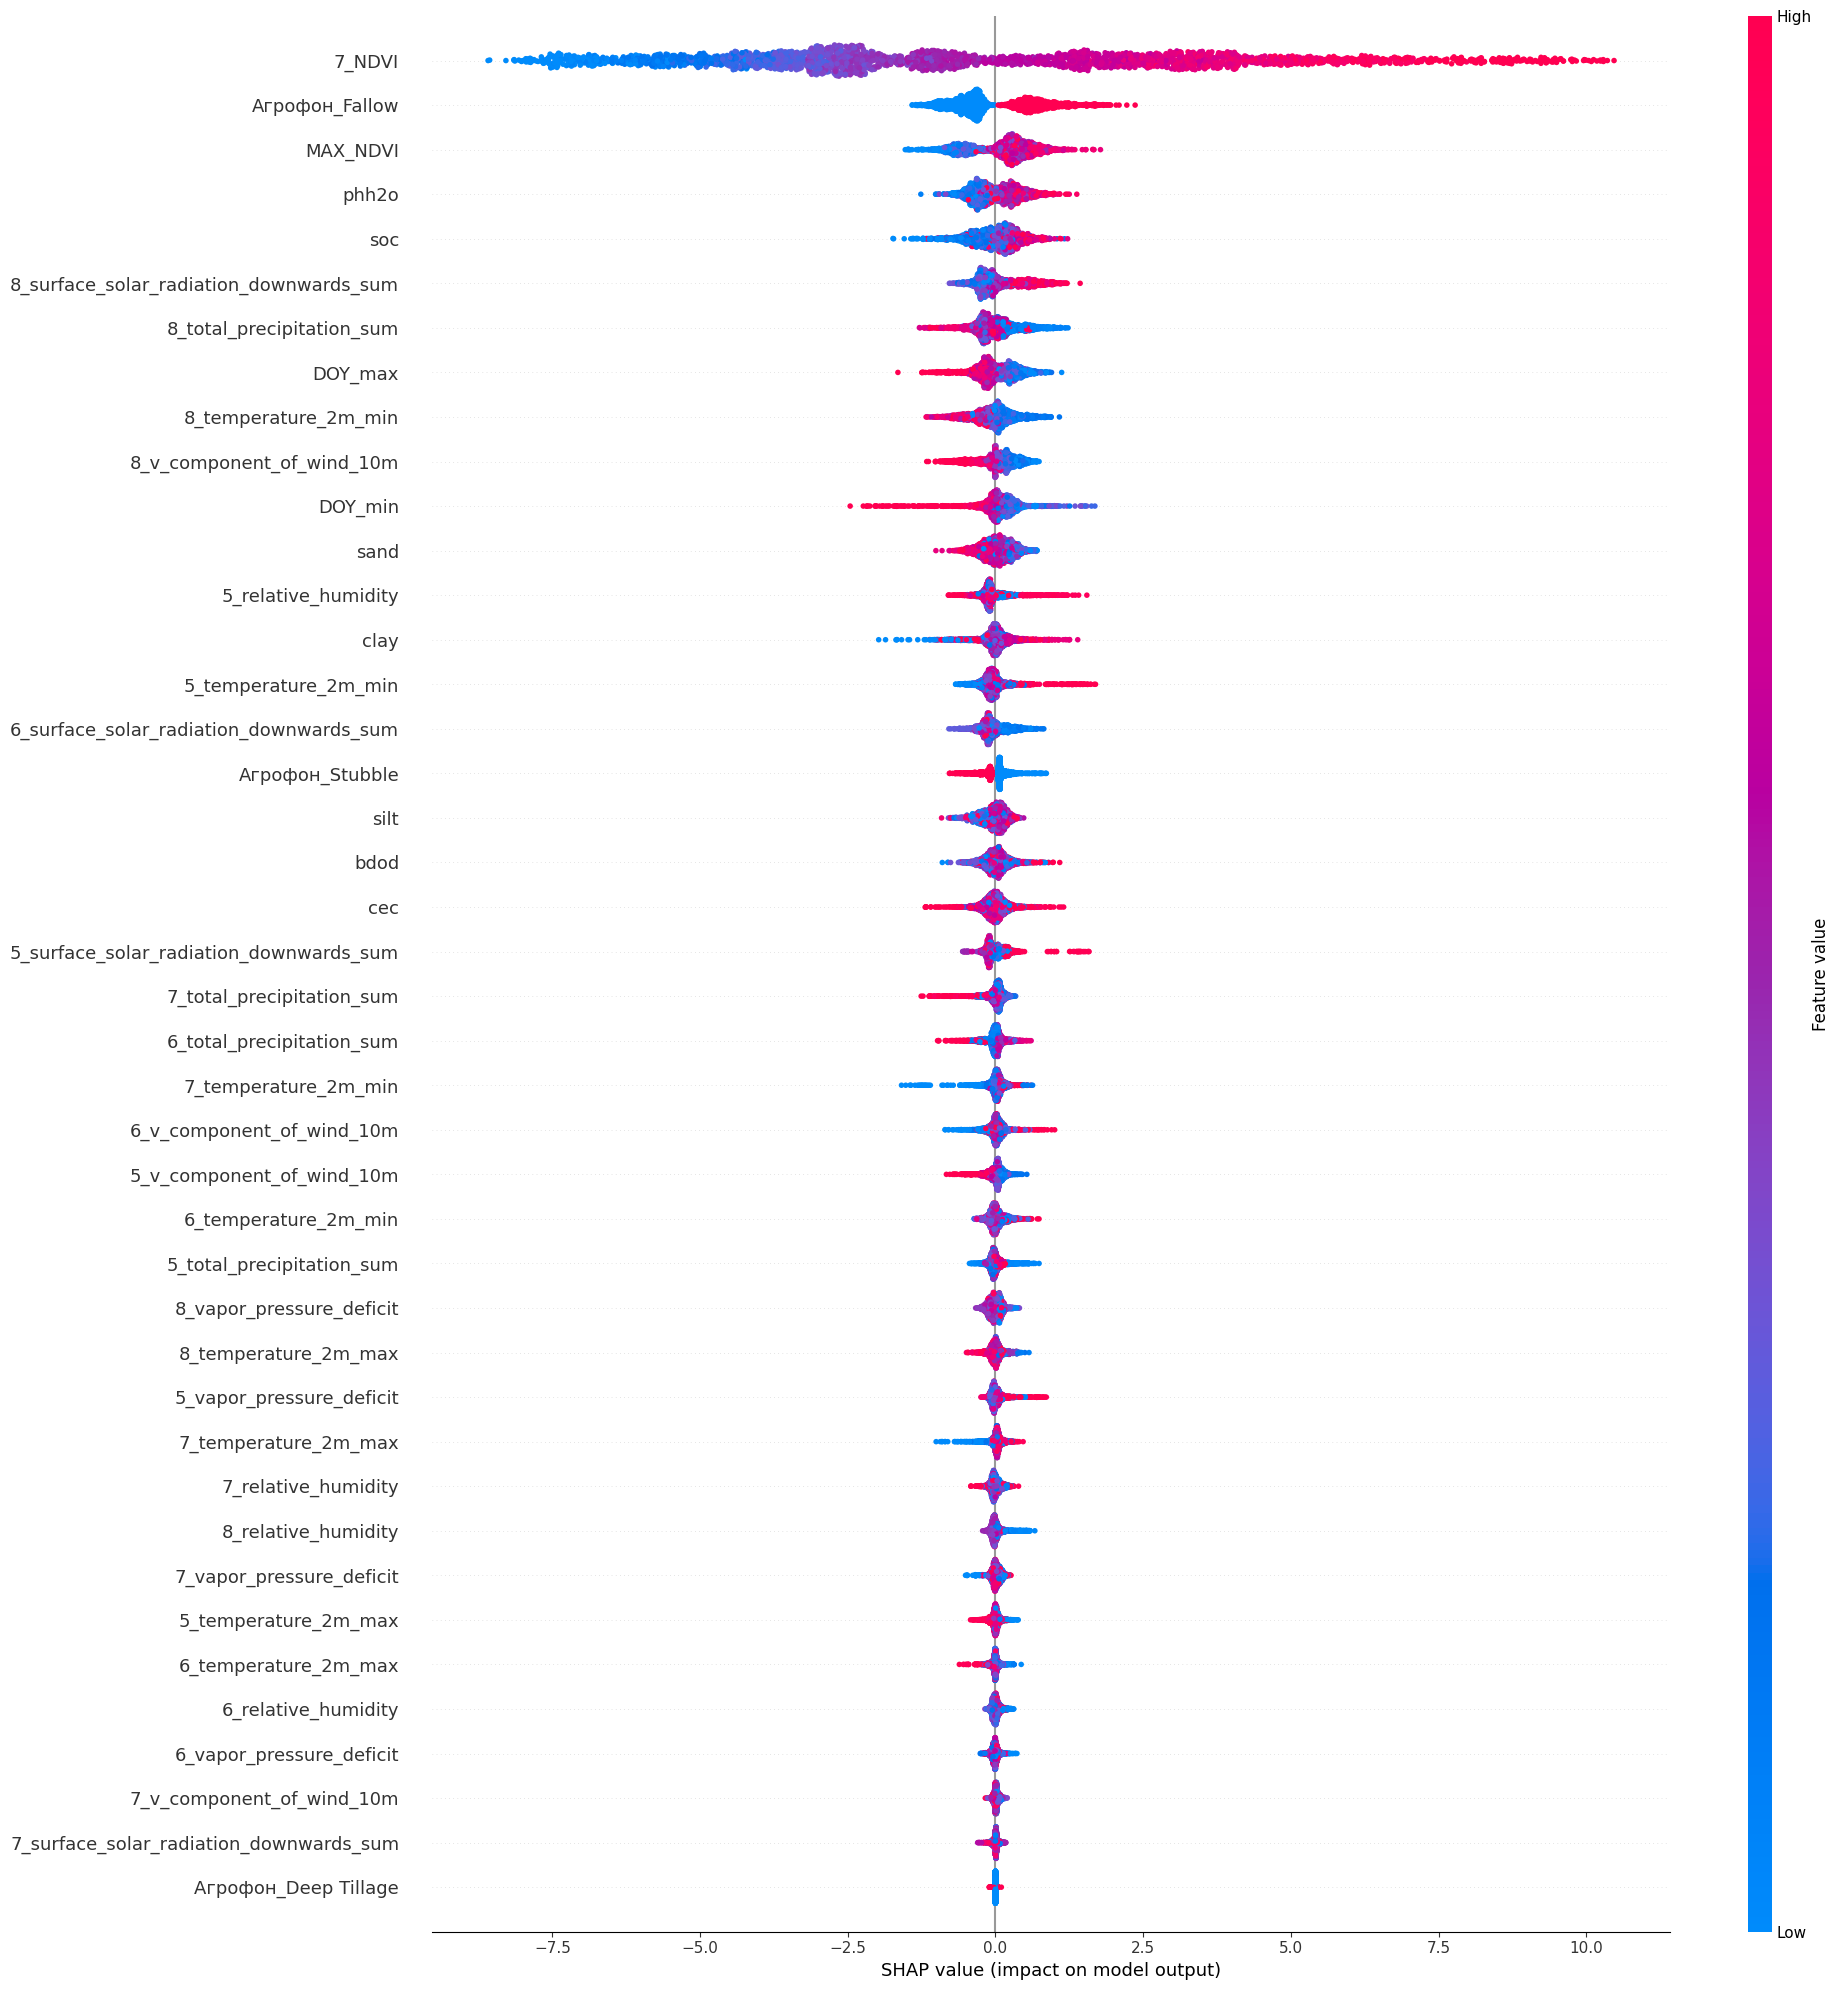

In [420]:
shap.summary_plot(data, preprocessed_df[features], plot_size=(20 ,20), max_display=60)

We see that Median NDVI for a field NDVI has a very big influence on yield predictions and is a vital feature to our model, because median NDVI for July represent peak growth and vegetation of wheat during the growing season, thus it has a very strong correlation with yield. The median NDVI also helps reduce a lot of noise in the field level NDVI data. The least influential features during training where climate features such as July Wind Speed, Surface Solar Radiation, and and Deep Tilage.

In [322]:
#Tune HyperParameters Using Optuna
def objective(trial):
    global best_score, training_rounds

    # Specify search space for hyperparameters
    param = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "feature_pre_filter": False,
        #"force_col_wise": True,  
        # Learning rate and iterations
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        # Tree-based parameters
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 5, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        # Regularization parameters
        "lambda_l1": trial.suggest_float("lambda_l1", 0.1, 70),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 70),

        # Sampling and feature selection parameters
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),

        "max_cat_threshold": trial.suggest_int("max_cat_threshold", 10, 32),
        # Fixed parameters
        #"n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "seed": 42
    }

    try:
        lgbfit = lgb.train(param,
                   dtrain,
                   num_boost_round = 100
                   )

        # Get predictions
        y_test_pred = lgbfit.predict(X_test)
        
        # Calculate MAEs
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        trial.set_user_attr('test_mae', test_mae)


        return test_mae

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        return float('inf')

In [323]:
# Setup and run Optuna study
study = optuna.create_study(
    direction='minimize'
)

# Run optimization
study.optimize(
    objective,
    n_trials=500,  # 4 hours
    timeout = 3600,
    n_jobs=2,  # Increase if you have multiple cores available
    show_progress_bar=True
)


[I 2025-01-30 13:46:43,379] A new study created in memory with name: no-name-78a6be11-0147-4bac-b1a8-1ed536e42c98


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-01-30 13:46:43,474] Trial 1 finished with value: 3.3148139588709724 and parameters: {'learning_rate': 0.08582404621746981, 'max_depth': 4, 'num_leaves': 6, 'min_child_samples': 26, 'lambda_l1': 61.30152981218609, 'lambda_l2': 59.66095441500643, 'feature_fraction': 0.22069256397870834, 'bagging_fraction': 0.46143415505217855, 'bagging_freq': 4, 'max_cat_threshold': 27}. Best is trial 1 with value: 3.3148139588709724.
[I 2025-01-30 13:46:43,519] Trial 0 finished with value: 3.589368884295423 and parameters: {'learning_rate': 0.018680913368577134, 'max_depth': 10, 'num_leaves': 8, 'min_child_samples': 14, 'lambda_l1': 54.09893067808935, 'lambda_l2': 24.408555898616484, 'feature_fraction': 0.9228935476430558, 'bagging_fraction': 0.6295335224859161, 'bagging_freq': 15, 'max_cat_threshold': 24}. Best is trial 1 with value: 3.3148139588709724.
[I 2025-01-30 13:46:43,561] Trial 2 finished with value: 3.767351860840198 and parameters: {'learning_rate': 0.02290060419577031, 'max_depth': 

In [324]:
# Get best parameters and scores
best_params = study.best_params
best_value = study.best_value

print("Best parameters:", best_params)
print("Best CV score:", best_value)
print("Number of finished trials:", len(study.trials))

Best parameters: {'learning_rate': 0.0999708881316216, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 13, 'lambda_l1': 10.904410483198347, 'lambda_l2': 3.242470744730208, 'feature_fraction': 0.7749319979298157, 'bagging_fraction': 0.7906446132738943, 'bagging_freq': 2, 'max_cat_threshold': 27}
Best CV score: 2.7857432475242123
Number of finished trials: 500


In [258]:
# Create importance plot
optuna.visualization.plot_param_importances(study)

In [393]:
params={"objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "feature_pre_filter": False,
'learning_rate': 0.0999708881316216, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 13, 'lambda_l1': 10.904410483198347, 'lambda_l2': 3.242470744730208, 'feature_fraction': 0.7749319979298157, 'bagging_fraction': 0.7906446132738943, 'bagging_freq': 2, 'max_cat_threshold': 27,
        "seed" : 42,
}

In [394]:
#Train a LightGBM model with tuned hyperparameters
dtrain = lgb.Dataset(X_train, label=y_train)

lgbfit = lgb.train(params,
                   dtrain,
                   num_boost_round=100
                   )

y_pred = lgbfit.predict(X_test)

mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (log scale): {mae_log}")
print(f"R-squared: {r2}")
print(f"Train MAE: {mean_absolute_error(y_train, lgbfit.predict(X_train))}")
print(f"R-squared: {r2_score(y_train, lgbfit.predict(X_train))}")

Mean Absolute Error (log scale): 2.7857432475242123
R-squared: 0.7031699572495941
Train MAE: 2.283160712008541
R-squared: 0.7925563056901855


After Tunning Hyperparameters we have reduced overfit significantly, thus making our model a lot more robust on unseen data.

In [352]:
lgbfit.save_model('lgbfit_new.txt')

In [395]:
#Determining How Much A Feature Contributes to Error between Predictions and Target Based On Shapley Values
def get_preds_shaps(df, features, target, ix_trn):
  dtrain = lgb.Dataset(df.loc[ix_trn, features], label=df.loc[ix_trn, target])
  model = lgb.train(params, dtrain, num_boost_round = 1000)
  preds = pd.Series(model.predict(df[features]), index=df.index)
  shap_explainer = shap.TreeExplainer(model)
  shaps = pd.DataFrame(
    data=shap_explainer.shap_values(df[features]),
    index=df.index,
    columns=features)
  return preds, shaps

def get_feature_contributions(y_true, y_pred, shap_values):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

  abs_error = (y_true - y_pred).abs()
  y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)
  abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y_true - feature).abs())
  error_contribution = abs_error_wo_feature.apply(lambda feature: abs_error - feature).mean().rename("error_contribution")
      
  return prediction_contribution, error_contribution

In [396]:
preds, shaps = get_preds_shaps(df=preprocessed_df, features=features, target=target, ix_trn=ix_trn)

prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
  y_true=preprocessed_df.loc[ix_trn, target], 
  y_pred=preds.loc[ix_trn], 
  shap_values=shaps.loc[ix_trn, :]
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
  y_true=preprocessed_df.loc[ix_val, target], 
  y_pred=preds.loc[ix_val], 
  shap_values=shaps.loc[ix_val, :]
)
contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

In [397]:
pd.set_option("display.max_rows", 10)

contributions_trn.sort_values("prediction_contribution", ascending=False).round(4).head(10)

,prediction_contribution,error_contribution
7_NDVI,3.1059,-2.3290
Агрофон_Fallow,0.7541,-0.2360
MAX_NDVI,0.7421,-0.3204
phh2o,0.4125,-0.1356
sand,0.3995,-0.1528
soc,0.3849,-0.1617
8_total_precipitation_sum,0.3466,-0.0895
5_surface_solar_radiation_downwards_sum,0.3364,-0.0666
DOY_max,0.3286,-0.1068
clay,0.3149,-0.1089


In [398]:
pd.set_option("display.max_rows", 30)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
7_NDVI,3.0408,-1.3661
MAX_NDVI,0.7566,-0.1060
Агрофон_Fallow,0.7411,-0.0660
DOY_min,0.2565,-0.0416
8_v_component_of_wind_10m,0.2669,-0.0388
6_surface_solar_radiation_downwards_sum,0.2711,-0.0359
8_surface_solar_radiation_downwards_sum,0.3021,-0.0351
DOY_max,0.3083,-0.0332
8_temperature_2m_min,0.1959,-0.0219
5_surface_solar_radiation_downwards_sum,0.3388,-0.0178


In [399]:
pd.set_option("display.max_rows", 30)

contributions_val.sort_values("error_contribution", ascending=False).round(4).head(10)

,prediction_contribution,error_contribution
6_v_component_of_wind_10m,0.1869,0.0168
silt,0.2430,0.0154
sand,0.4031,0.0131
8_vapor_pressure_deficit,0.1748,0.0095
8_relative_humidity,0.1571,0.0087
cec,0.2235,0.0083
7_v_component_of_wind_10m,0.1067,0.0049
5_total_precipitation_sum,0.1482,0.0036
phh2o,0.4108,0.0031
6_temperature_2m_max,0.0857,0.0029


We can see again that excluding 7_NDVI has strong negative contributions to the prediction accuracy of our model thus cementing once more how important of a feature it is to the model. Whearas the features that contributes the most to error is June Wind Speed, however the contribution is very small or neglegible